# Entrenando un modelo de Imágenes en Google Colab (CPU vs GPU)


## Contexto

El conjunto de datos MNIST (Modified National Institute of Standards and Technology) es un conjunto de referencia en el campo del aprendizaje automático y la visión por computadora, especialmente para problemas de clasificación de imágenes.

Consiste en 70,000 imágenes en escala de grises de dígitos escritos a mano (del 0 al 9). Cada imagen es de 28×28 píxeles, lo que resulta en 784 características por instancia. De estas imágenes, 60,000 constituyen el conjunto de entrenamiento y 10,000 el conjunto de prueba. 

Con ellos se plantea un problema supervisado de clasificación donde se entrenando modelos para que, a partir de la imagen de los dígitos, se prediga a que dígito correspode.


![MNIST](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

In [ ]:
!uname -a # Comando que nos da información del sistema operativo

Linux 8cfd2a59c287 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [ ]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.72MB/s]

60000


Label: 5


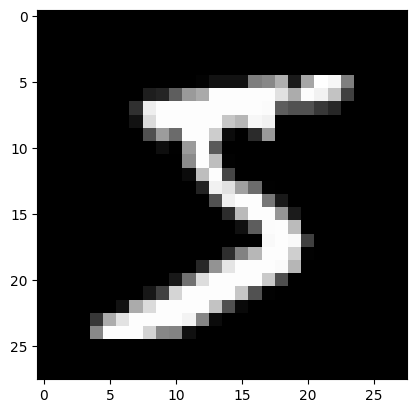

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [ ]:
# --- 1. Configuración y Hiperparámetros ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


In [ ]:
# Hiperparámetros
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS = 2
LR = 0.01
GAMMA = 0.7

In [ ]:
%%time
# --- 2. Carga y Transformación de Datos ---

# Define las transformaciones para los datos
# ToTensor convierte la imagen a Tensor y normaliza los píxeles a [0, 1]
# Normalize ajusta la media y la desviación estándar para acelerar el entrenamiento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Carga del conjunto de entrenamiento
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Carga del conjunto de prueba
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

# --- 3. Definición del Modelo (CNN) ---
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Primera capa convolucional: 1 canal de entrada (escala de grises) a 32 canales de salida
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Segunda capa convolucional: 32 canales de entrada a 64 canales de salida
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Capa lineal (Fully Connected)
        self.fc1 = nn.Linear(9216, 128) # 9216 es (64 canales * 12 * 12) despues del MaxPooling
        self.fc2 = nn.Linear(128, 10)   # 10 clases de salida (dígitos 0-9)

    def forward(self, x):
        # Aplicar conv1 -> ReLU -> MaxPooling (2x2)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        # Aplanar la salida convolucional para la capa lineal
        x = torch.flatten(x, 1)

        # Aplicar fc1 -> ReLU
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Capa de salida
        x = self.fc2(x)
        # log_softmax para obtener logaritmos de probabilidades de clase
        output = F.log_softmax(x, dim=1)
        return output

# Inicializa el modelo y lo mueve al dispositivo
model = Net().to(device)
# Define el optimizador y el planificador de la tasa de aprendizaje
optimizer = optim.Adadelta(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=GAMMA)

# --- 4. Función de Entrenamiento ---
def train(model, device, train_loader, optimizer, epoch):
    model.train() # Pone el modelo en modo entrenamiento
    for batch_idx, (data, target) in enumerate(train_loader):
        # Mueve los datos y las etiquetas al dispositivo
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad() # Limpia los gradientes anteriores
        output = model(data)  # Pase adelante

        # Calcula la pérdida (Negative Log Likelihood Loss)
        loss = F.nll_loss(output, target)

        loss.backward()       # Pase hacia atrás (calcula gradientes)
        optimizer.step()      # Actualiza los pesos del modelo

        # Imprime el progreso
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# --- 5. Función de Prueba ---
def test(model, device, test_loader):
    model.eval() # Pone el modelo en modo evaluación
    test_loss = 0
    correct = 0
    with torch.no_grad(): # Desactiva el cálculo de gradientes
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Suma la pérdida por lote
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Obtiene la clase predicha (índice del log-prob máximo)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

    return 100. * correct / len(test_loader.dataset)

# --- 6. Bucle de Entrenamiento Principal ---
print("\n--- Iniciando Entrenamiento ---")
best_accuracy = 0.0

for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)

    # Ajusta la tasa de aprendizaje
    scheduler.step()

    # Guarda el mejor modelo
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "mnist_cnn.pt")
        print(f"Modelo guardado con Accuracy: {best_accuracy:.2f}%")

print("\n--- Entrenamiento Finalizado ---")


--- Iniciando Entrenamiento ---
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305989
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.584855
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.949045
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.662705
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.631688
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.481850
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.413026
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.482249
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.448070
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.225468

Test set: Average loss: 0.2852, Accuracy: 9172/10000 (92%)

Modelo guardado con Accuracy: 91.72%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.314746
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.308141
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.441968
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.401464
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.417878
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.253925
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.478263
Train Epoch: 2 [44800/60000 (75